In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import joblib

In [14]:
# Load data
csv_path = r"C:\Users\vindu\Downloads\creditcard.csv"
raw_df = pd.read_csv(csv_path)
df = raw_df.copy()

In [15]:
# Preprocessing
df['normalizedAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['normalizedTime'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [17]:
# SMOTE Oversampling
sm = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [18]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', scale_pos_weight=284315 / 492, use_label_encoder=False)
}


Training Logistic Regression...
Confusion Matrix:
 [[83344  1951]
 [   18   130]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC-AUC: 0.9657 | PR-AUC: 0.7079


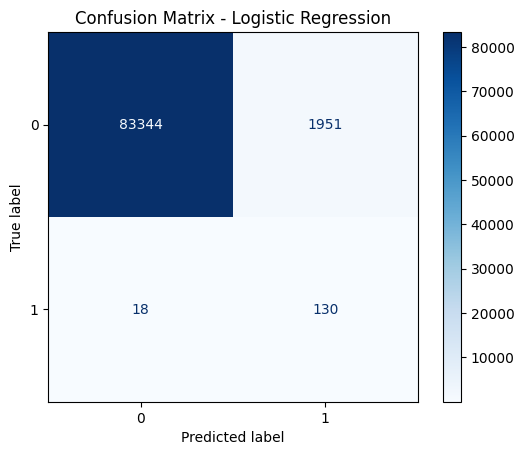


Training Random Forest...
Confusion Matrix:
 [[85280    15]
 [   36   112]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.76      0.81       148

    accuracy                           1.00     85443
   macro avg       0.94      0.88      0.91     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC: 0.9523 | PR-AUC: 0.8184


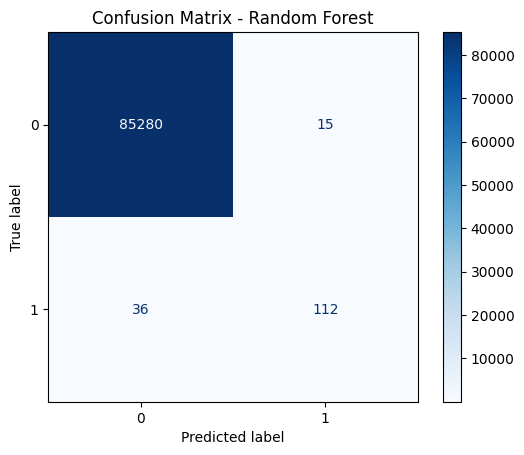


Training XGBoost...


C:\Users\vindu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:14:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[85231    64]
 [   29   119]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.65      0.80      0.72       148

    accuracy                           1.00     85443
   macro avg       0.82      0.90      0.86     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC: 0.9608 | PR-AUC: 0.8178


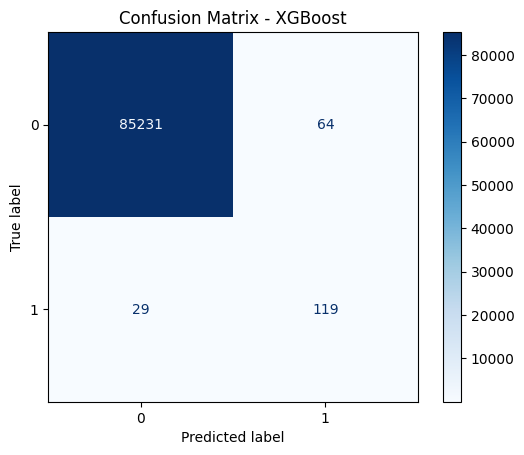

In [19]:
# Model training and evaluation
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    roc_auc = roc_auc_score(y_test, y_score)
    pr_auc = average_precision_score(y_test, y_score)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")

    results[name] = {
        'model': model,
        'conf_matrix': confusion_matrix(y_test, y_pred),
        'report': classification_report(y_test, y_pred, output_dict=True),
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_score': y_score
    }
    
    # Confusion Matrix Plot
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [20]:
# Summary Table
summary_df = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC-AUC': [results[m]['roc_auc'] for m in results],
    'PR-AUC': [results[m]['pr_auc'] for m in results]
}).sort_values(by='PR-AUC', ascending=False)
print("\nModel Performance Summary:\n", summary_df)

# Select Best Model by PR-AUC
best_model_name = summary_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name} (PR-AUC={summary_df.iloc[0]['PR-AUC']:.4f})")


Model Performance Summary:
                  Model   ROC-AUC    PR-AUC
1        Random Forest  0.952280  0.818362
2              XGBoost  0.960778  0.817801
0  Logistic Regression  0.965665  0.707906

Best model: Random Forest (PR-AUC=0.8184)


In [21]:
# Save Best Model
joblib.dump(best_model, f"{best_model_name.replace(' ', '_').lower()}_best_model.joblib")
print(f"Best model saved as {best_model_name.replace(' ', '_').lower()}_best_model.joblib")

Best model saved as random_forest_best_model.joblib


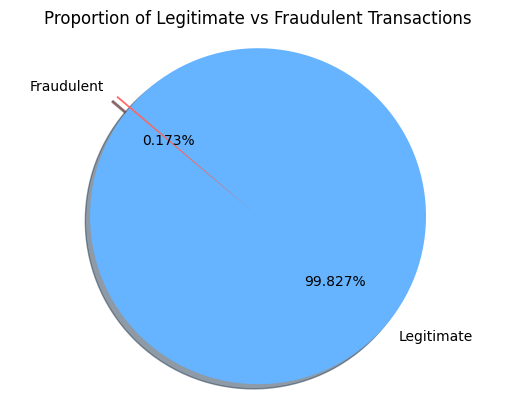

In [22]:
# Visualizations
## Class Distribution (Pie Chart)
fraud_counts = raw_df['Class'].value_counts()
plt.pie(fraud_counts, labels=['Legitimate', 'Fraudulent'],
        colors=['#66b3ff', '#ff6666'], explode=(0, 0.1),
        autopct='%1.3f%%', startangle=140, shadow=True)
plt.title('Proportion of Legitimate vs Fraudulent Transactions')
plt.axis('equal')
plt.show()

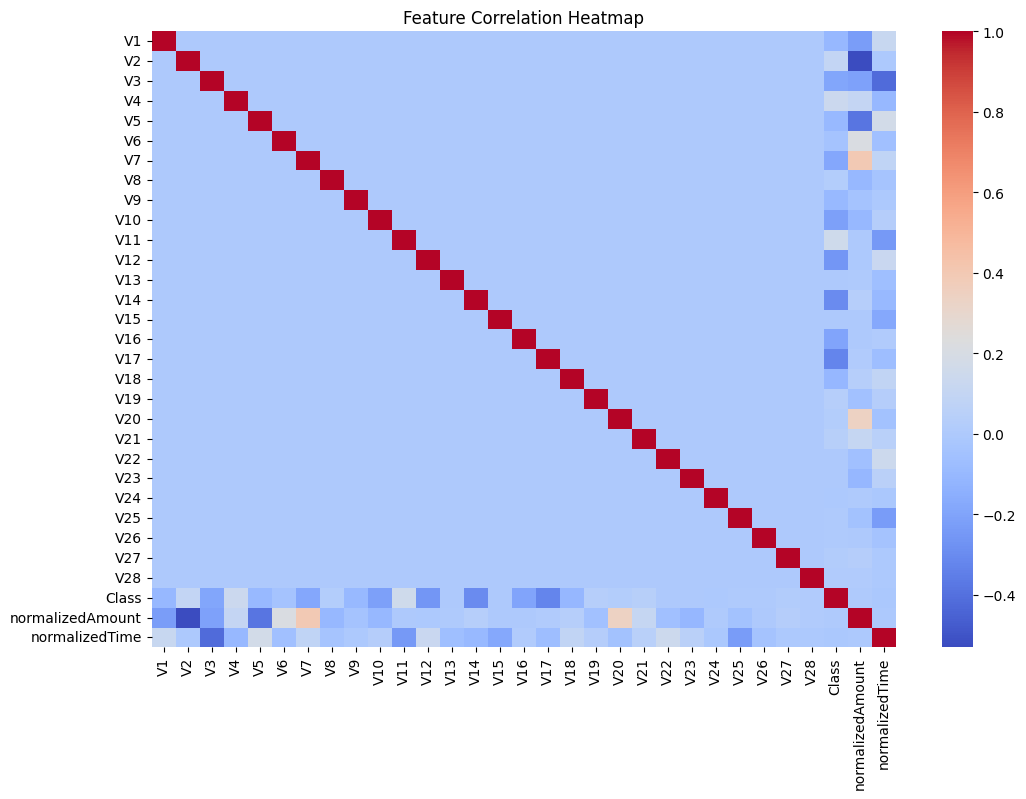

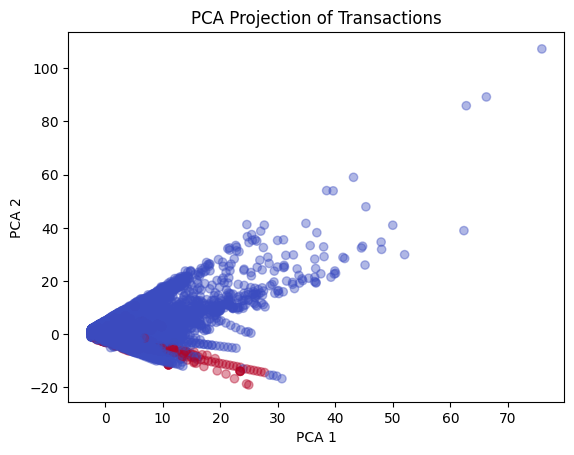

In [23]:
## Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.4)
plt.title('PCA Projection of Transactions')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

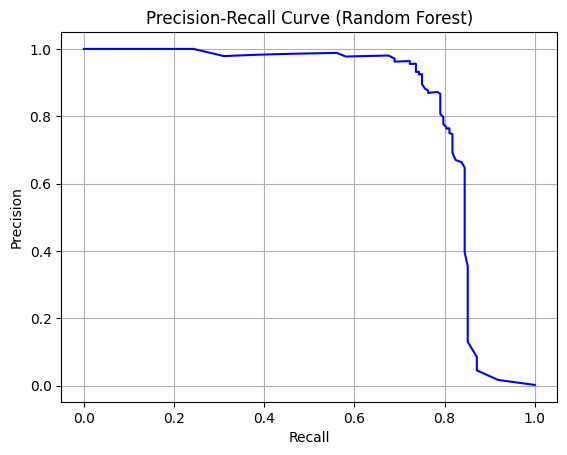

In [24]:
## Precision-Recall Curve for Best Model
precision, recall, _ = precision_recall_curve(y_test, results[best_model_name]['y_score'])
plt.plot(recall, precision, color='blue')
plt.title(f'Precision-Recall Curve ({best_model_name})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

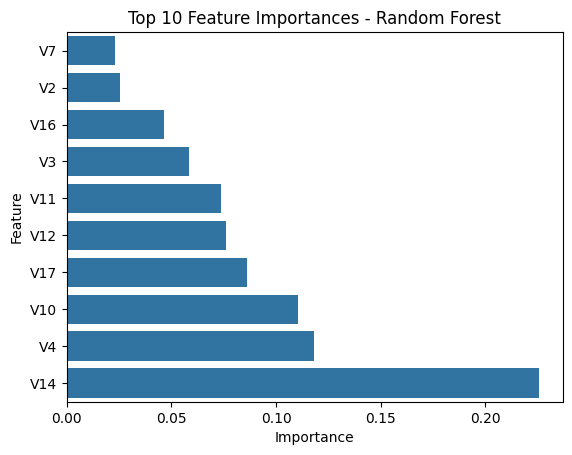

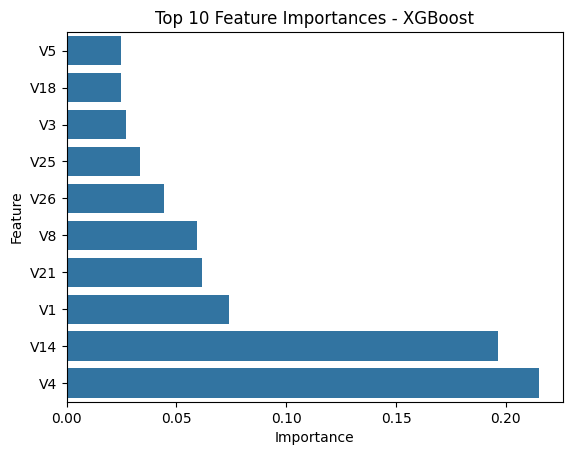

In [25]:
## Feature Importance for Tree Models
for name in ['Random Forest', 'XGBoost']:
    if name in results and hasattr(results[name]['model'], 'feature_importances_'):
        importances = results[name]['model'].feature_importances_
        indices = np.argsort(importances)[-10:]
        sns.barplot(x=importances[indices], y=X.columns[indices])
        plt.title(f"Top 10 Feature Importances - {name}")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()

In [27]:
# ===============================
# LOAD & PREDICT ON DATA
# ===============================
print("\nLoading best model and predicting on a known fraud sample...")
loaded_model = joblib.load(f"{best_model_name.replace(' ', '_').lower()}_best_model.joblib")

fraud_sample = raw_df[raw_df['Class'] == 1].iloc[0:1].copy()
fraud_sample['normalizedAmount'] = StandardScaler().fit_transform(fraud_sample['Amount'].values.reshape(-1, 1))
fraud_sample['normalizedTime'] = StandardScaler().fit_transform(fraud_sample['Time'].values.reshape(-1, 1))
fraud_sample.drop(['Time', 'Amount', 'Class'], axis=1, inplace=True)

prediction = loaded_model.predict(fraud_sample)[0]
print(f"Predicted class for known fraud transaction: {'Fraud' if prediction == 1 else 'Legit'}")


Loading best model and predicting on a known fraud sample...
Predicted class for known fraud transaction: Fraud
